In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

## Loading the data

In [2]:
train = pd.read_csv('Tweets.csv', index_col = 'tweet_id')
train.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
train.shape

(14640, 14)

## Subsetting relevant columns for further analysis

In [4]:
train = train.iloc[:, [0,4,9]]
train.head(10)

,airline_sentiment,airline,text
tweet_id,,,
570306133677760513,neutral,Virgin America,@VirginAmerica What @dhepburn said.
570301130888122368,positive,Virgin America,@VirginAmerica plus you've added commercials t...
570301083672813571,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
570301031407624196,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
570300817074462722,negative,Virgin America,@VirginAmerica and it's a really big bad thing...
570300767074181121,negative,Virgin America,@VirginAmerica seriously would pay $30 a fligh...
570300616901320704,positive,Virgin America,"@VirginAmerica yes, nearly every time I fly VX..."
570300248553349120,neutral,Virgin America,@VirginAmerica Really missed a prime opportuni...
570299953286942721,positive,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D"


## EDA to estimate sentiment type for each airline 

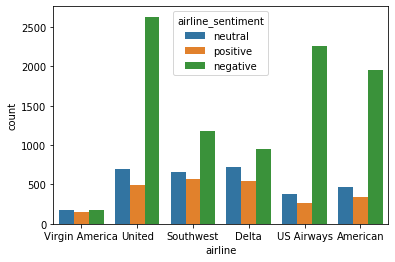

In [5]:
sns.countplot('airline', hue = 'airline_sentiment', data = train)

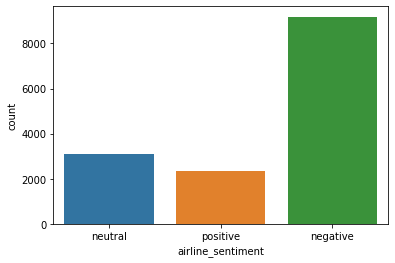

In [6]:
sns.countplot('airline_sentiment', data = train)

## Creating One-Hot encoding for airline column 

In [7]:
train = pd.get_dummies(train, columns = ['airline'])

## Converting the response in numeric format

In [8]:
train['airline_sentiment'] = train['airline_sentiment'].map({'neutral':1, 'positive':2, 'negative':0})

In [9]:
train.head(10)

,airline_sentiment,text,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
tweet_id,,,,,,,,
570306133677760513,1,@VirginAmerica What @dhepburn said.,0,0,0,0,0,1
570301130888122368,2,@VirginAmerica plus you've added commercials t...,0,0,0,0,0,1
570301083672813571,1,@VirginAmerica I didn't today... Must mean I n...,0,0,0,0,0,1
570301031407624196,0,@VirginAmerica it's really aggressive to blast...,0,0,0,0,0,1
570300817074462722,0,@VirginAmerica and it's a really big bad thing...,0,0,0,0,0,1
570300767074181121,0,@VirginAmerica seriously would pay $30 a fligh...,0,0,0,0,0,1
570300616901320704,2,"@VirginAmerica yes, nearly every time I fly VX...",0,0,0,0,0,1
570300248553349120,1,@VirginAmerica Really missed a prime opportuni...,0,0,0,0,0,1
570299953286942721,2,"@virginamerica Well, I didn't…but NOW I DO! :-D",0,0,0,0,0,1


In [10]:
X_train = train.drop(columns = 'airline_sentiment')
y_train = train['airline_sentiment']

## Creating words vectorizer of length 1 and 2  

In [11]:
word_vect = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5, 
                            stop_words='english', 
                            analyzer='word', 
                            ngram_range = (1,2), 
                            sublinear_tf = True)


word_vect.fit(X_train['text'])
X_train_word_features = word_vect.transform(X_train['text'])

In [12]:
feature_names = np.array(word_vect.get_feature_names())
print(len(word_vect.get_feature_names()))

4906


In [13]:
feature_names = np.array(word_vect.get_feature_names())
print('Some elements of feature names in word vectorizer are:\n{}\n'.format(feature_names[::200]))

Some elements of feature names in word vectorizer are:
['00' '9am' 'americanair really' 'bag amp' 'car seat' 'confusion'
 'department' 'emailed' 'flight' 'flying southwest' 'grr' 'hours help'
 'jetblue plane' 'line' 'messaged' 'oakland' 'plane hours' 'redcarpet'
 'seat flight' 'southwestair fly' 'svc' 'training' 'united love'
 'usairways stuck' 'whats']



## Creating character vectorizer of length 3 to 6

In [14]:
char_vect = TfidfVectorizer(strip_accents ='unicode', 
                            min_df=5, 
                            stop_words='english', 
                            analyzer='char', 
                            ngram_range = (3,6), 
                            sublinear_tf = True, 
                            max_features = 10000)


char_vect.fit(X_train['text'])
X_train_char_features = char_vect.transform(X_train['text'])

In [15]:
## Stacking for the arrays together
X_train_final = hstack([X_train_word_features, X_train_char_features, X_train.drop(columns = 'text')])

## Logistic Model

In [16]:
model_logistic = LogisticRegression(C = 0.1, multi_class = 'multinomial', solver = 'lbfgs')
cv_score = np.mean(cross_val_score(model_logistic, X_train_final, y_train, cv=10, scoring='accuracy'))
print(cv_score)

0.72963816718191


## Naive Bayes Model

In [17]:
model_NB = MultinomialNB()
cv_score = np.mean(cross_val_score(model_NB, X_train_final, y_train, cv=10, scoring='accuracy'))
print(cv_score)

0.7366074494755378


## Random Forest Model

In [18]:
model_random_forest = RandomForestClassifier(n_estimators=500, min_samples_leaf = 5)
model_random_forest.fit(X_train_final, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
model_random_forest.score(X_train_final, y_train)

0.8384562841530054

## Words with highest and lowest coefficient value 

In [20]:
model_logistic = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
model_logistic.fit(X_train_word_features, y_train)
sorted_coef_index = model_logistic.coef_[0].argsort()
print('Words with Smallest Coefs values are :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Words with Largest Coefs values are : \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Words with Smallest Coefs values are :
['thank' 'thanks' 'virginamerica' 'jetblue' 'southwestair' 'love'
 'awesome' 'great' 'amazing' 'kudos']

Words with Largest Coefs values are : 
['hours' 'worst' 'hold' 'delayed' 'hour' 'delay' 'luggage' 'hrs' 'fail'
 'stuck']



C:\Users\singh\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Words with highest and lowest tfidf value 

In [21]:
sorted_tfidf_index = X_train_word_features.max(0).toarray()[0].argsort()
print('Words with smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Words with largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Words with smallest tfidf:
['cessna 747' 'folks cessna' 'airport snow' 'cessna' 'removal method'
 'method 22' 'snow removal' 'removal' '22 good' 'work folks']

Words with largest tfidf: 
['americanair' 'virginamerica' 'jetblue' 'united' 'southwestair'
 'usairways' 'rude' 'https' '25' 'aisle']


# Deep Learning Models (through Keras)

In [22]:
X = train['text']
y = train['airline_sentiment']

In [23]:
token = Tokenizer()
token.fit_on_texts(X)

In [24]:
word_index = token.word_index

In [25]:
vocab_size = len(word_index) + 1

In [26]:
sequences = token.texts_to_sequences(X)

In [27]:
max_len = 0
for i in sequences:
    x = len(i)
    if x > max_len:
        max_len = x
    else:
        continue
max_len

36

In [28]:
padded_X = pad_sequences(sequences, maxlen = max_len, padding = 'post')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size = 0.2, random_state = 0)

In [30]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 36)
y_train size: (11712,)
X_test size: (2928, 36)
y_test size: (2928,)


## Using only flat layers 

In [31]:
flat_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
flat_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
flat_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 100)           1576900   
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                115232    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,692,231
Trainable params: 1,692,231
Non-trainable params: 0
______________________________________________

In [32]:
flat_model_fit = flat_model.fit(X_train, y_train, epochs = 10, validation_split = 0.2)

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 7s 752us/sample - loss: 0.7384 - accuracy: 0.6835 - val_loss: 0.5672 - val_accuracy: 0.7768
Epoch 2/10
9369/9369 [==============================] - 7s 756us/sample - loss: 0.3868 - accuracy: 0.8574 - val_loss: 0.5376 - val_accuracy: 0.7904
Epoch 3/10
9369/9369 [==============================] - 7s 757us/sample - loss: 0.1538 - accuracy: 0.9524 - val_loss: 0.6000 - val_accuracy: 0.7956
Epoch 4/10
9369/9369 [==============================] - 7s 712us/sample - loss: 0.0646 - accuracy: 0.9833 - val_loss: 0.6882 - val_accuracy: 0.7875
Epoch 5/10
9369/9369 [==============================] - 7s 738us/sample - loss: 0.0409 - accuracy: 0.9909 - val_loss: 0.7579 - val_accuracy: 0.7866
Epoch 6/10
9369/9369 [==============================] - 7s 728us/sample - loss: 0.0303 - accuracy: 0.9924 - val_loss: 0.8232 - val_accuracy: 0.7819
Epoch 7/10
9369/9369 [==============================] - 7s 739us

In [33]:
loss, accuracy = flat_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7862


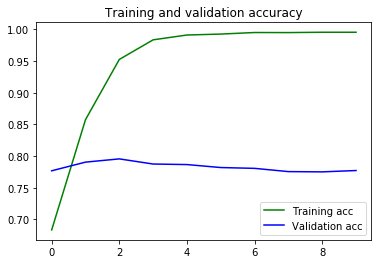

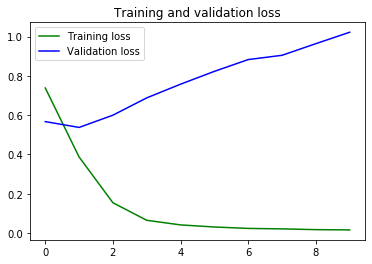

In [34]:
# Plot train/test loss and accuracy
acc = flat_model_fit.history['accuracy']
val_acc = flat_model_fit.history['val_accuracy']
loss = flat_model_fit.history['loss']
val_loss = flat_model_fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using Single Directional LSTM

In [35]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
    tf.keras.layers.LSTM(256, dropout = 0.2, recurrent_dropout = 0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           1576900   
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 256)               365568    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 1,943,239
Trainable params: 1,943,239
Non-trainable params: 0
_________________________________________________________________


In [36]:
lstm_model_fit = lstm_model.fit(X_train, y_train, epochs = 10, validation_split = 0.2)

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 57s 6ms/sample - loss: 0.8357 - accuracy: 0.6374 - val_loss: 0.7027 - val_accuracy: 0.6983
Epoch 2/10
9369/9369 [==============================] - 56s 6ms/sample - loss: 0.6707 - accuracy: 0.7091 - val_loss: 0.6619 - val_accuracy: 0.7102
Epoch 3/10
9369/9369 [==============================] - 57s 6ms/sample - loss: 0.5553 - accuracy: 0.7564 - val_loss: 0.6764 - val_accuracy: 0.7081
Epoch 4/10
9369/9369 [==============================] - 57s 6ms/sample - loss: 0.4876 - accuracy: 0.7894 - val_loss: 0.6457 - val_accuracy: 0.7465
Epoch 5/10
9369/9369 [==============================] - 56s 6ms/sample - loss: 0.4079 - accuracy: 0.8447 - val_loss: 0.7049 - val_accuracy: 0.7623
Epoch 6/10
9369/9369 [==============================] - 57s 6ms/sample - loss: 0.3376 - accuracy: 0.8836 - val_loss: 0.6856 - val_accuracy: 0.7661
Epoch 7/10
9369/9369 [==============================] - 57s 6ms/sample

In [37]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7664


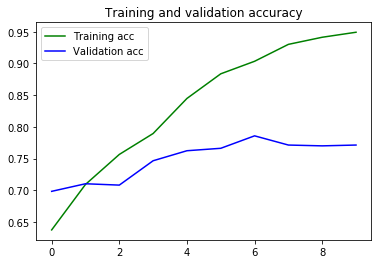

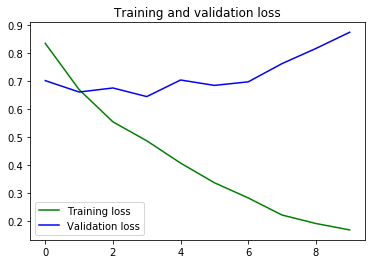

In [38]:
# Plot train/test loss and accuracy
acc = lstm_model_fit.history['accuracy']
val_acc = lstm_model_fit.history['val_accuracy']
loss = lstm_model_fit.history['loss']
val_loss = lstm_model_fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using Bidirectional LSTM

In [39]:
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
    tf.keras.layers.Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.5)),
    tf.keras.layers.Dense(3, activation='softmax')
])
bi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 36, 100)           1576900   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 1,661,767
Trainable params: 1,661,767
Non-trainable params: 0
_________________________________________________________________


In [40]:
bi_lstm_model_fit = bi_lstm_model.fit(X_train, y_train, epochs = 10, validation_split = 0.2)

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 31s 3ms/sample - loss: 0.7080 - accuracy: 0.7028 - val_loss: 0.5495 - val_accuracy: 0.7768
Epoch 2/10
9369/9369 [==============================] - 30s 3ms/sample - loss: 0.4410 - accuracy: 0.8310 - val_loss: 0.5121 - val_accuracy: 0.8054
Epoch 3/10
9369/9369 [==============================] - 29s 3ms/sample - loss: 0.3113 - accuracy: 0.8886 - val_loss: 0.5347 - val_accuracy: 0.7964
Epoch 4/10
9369/9369 [==============================] - 29s 3ms/sample - loss: 0.2292 - accuracy: 0.9205 - val_loss: 0.6192 - val_accuracy: 0.7917
Epoch 5/10
9369/9369 [==============================] - 30s 3ms/sample - loss: 0.1734 - accuracy: 0.9404 - val_loss: 0.6809 - val_accuracy: 0.7947
Epoch 6/10
9369/9369 [==============================] - 29s 3ms/sample - loss: 0.1351 - accuracy: 0.9560 - val_loss: 0.7689 - val_accuracy: 0.7853
Epoch 7/10
9369/9369 [==============================] - 30s 3ms/sample

In [41]:
loss, accuracy = bi_lstm_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7770


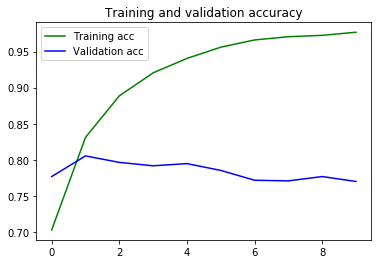

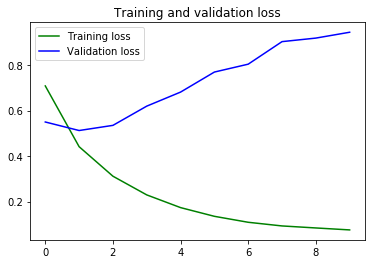

In [42]:
# Plot train/test loss and accuracy
acc = bi_lstm_model_fit.history['accuracy']
val_acc = bi_lstm_model_fit.history['val_accuracy']
loss = bi_lstm_model_fit.history['loss']
val_loss = bi_lstm_model_fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()